In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [2]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 5.4 MB/s eta 0:00:00


In [6]:
current_path = os.getcwd()
current_path


'/content'

In [8]:
step2_fs_results_save_path

'/content/gdrive/Othercomputers/My Computer/Fire_risk_main/data/hongru_share//step_2/fire_spread/results/'

In [16]:
import pandas as pd
import os
import numpy as np
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.metrics import make_scorer,f1_score

current_path = os.getcwd()
root_path = os.path.dirname(current_path)
root_path = os.path.dirname(root_path)
root_path = '/content/gdrive/Othercomputers/My Computer/Fire_risk_main/Fire_risk_main/data/Fire-data-paper-hongru_share/'
data_path= root_path + '/github_repo/data/'

In [11]:
import sys
print(sys.version)

!pip show catboost

!pip show scikit-learn


3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]
Name: catboost
Version: 1.2.8
Summary: CatBoost Python Package
Home-page: https://catboost.ai
Author: CatBoost Developers
Author-email: 
License: Apache License, Version 2.0
Location: /usr/local/lib/python3.11/dist-packages
Requires: graphviz, matplotlib, numpy, pandas, plotly, scipy, six
Required-by: 
Name: scikit-learn
Version: 1.6.1
Summary: A set of python modules for machine learning and data mining
Home-page: https://scikit-learn.org
Author: 
Author-email: 
License: BSD 3-Clause License

 Copyright (c) 2007-2024 The scikit-learn developers.
 All rights reserved.

 Redistribution and use in source and binary forms, with or without
 modification, are permitted provided that the following conditions are met:

 * Redistributions of source code must retain the above copyright notice, this
   list of conditions and the following disclaimer.

 * Redistributions in binary form must reproduce the above copyright notice,
   this list of co

In [12]:
package_versions = {
    'pandas': pd.__version__,
    'os': 'builtin',
    'numpy': np.__version__,
    #'catboost': catboost.__version__,
    #'scikit-learn': sklearn.__version__,
    #'matplotlib': matplotlib.__version__,
    'seaborn': sns.__version__,
    'joblib': joblib.__version__
}

package_versions

{'pandas': '2.2.2',
 'os': 'builtin',
 'numpy': '2.0.2',
 'seaborn': '0.13.2',
 'joblib': '1.5.1'}

In [17]:
filename='step2_consequence_fire_spread.pkl'

In [18]:
df=pd.read_pickle(data_path + filename)

In [19]:
#df['FIRE_SPRD'].value_counts()
proportions = df['FIRE_SPRD'].value_counts(normalize=True)
proportions


,proportion
FIRE_SPRD,
2,0.484949
4,0.347111
3,0.113053
5,0.054888


In [21]:
df=df[df['CAUSE_IGN']!='0']
df=df[df['HEAT_SOURCE_new']!='6']
df=df[df['FACT_IGN1_new']!='7']
df=df[df['AREA_ORIG_new']!='8']
df=df[df['AREA_ORIG_new']!='9']

def remove_outliers_z(df, columns, threshold=3):
    for col in columns:
        z_scores = (df[col] - df[col].mean()) / df[col].std()
        df = df[(z_scores < threshold) & (z_scores > -threshold)]
    return df

df = df[(df['last_unit_clear_time'] < 600)&(df['TOT_SQ_FT'] < 50000)].reset_index().drop(columns = ['index'])


In [22]:
cpi_map={'2012':1,
         '2013':1.02,
         '2014':1.02,
         '2015':1.03,
         '2016':1.05,
         '2017':1.07,
         '2018':1.09,
         '2019':1.12,
         '2020':1.13,
         '2021':1.21,
         '2022':1.29
}
df['median_income_list'] = df.apply(lambda row: row['median_income_list'] / cpi_map.get(row['accident_year'], 1)*1.29, axis=1)
df['median_rent_list'] = df.apply(lambda row: row['median_rent_list'] / cpi_map.get(row['accident_year'], 1)*1.29, axis=1)


In [23]:
columns_drop=['DET_OPERAT','build_time_1939_and_earlier_list','build_time_1940_to_1979_list','total_population_list','SUP_APP', 'EMS_APP', 'OTH_APP','Pct_GRAPI_35_pct_or_more_list',
       'Pct_GRAPI_Less_than_15_pct_list','Pct_EDU_Less_than_9th_grade_list',
       'SUP_PER', 'EMS_PER', 'OTH_PER','AID','pop_density']
df.drop(columns=columns_drop,inplace=True)

In [25]:
df.shape

(672340, 53)

In [26]:
counts = df.groupby(['CBSA Title']).size().reset_index(name='count')

# Keep only those with count >= 2
valid_pairs = counts[counts['count'] >= 5][['CBSA Title','count']]

# Merge to filter the DataFrame
df_filtered = df.merge(valid_pairs, on=['CBSA Title'])

In [27]:
df_filtered.columns

Index(['STATE', 'NUM_UNIT', 'CAUSE_IGN', 'FIRE_SPRD', 'BLDG_ABOVE',
       'BLDG_BELOW', 'TOT_SQ_FT', 'FIRE_ORIG', 'FLAME_SPRD', 'DETECTOR',
       'AES_PRES', 'INCIDENT_KEY', 'APP_MOD', 'response_time',
       'last_unit_clear_time', 'accident_year', 'accident_month',
       'accident_day', 'accident_hour', 'median_income_list',
       'median_rent_list', 'Pct_HOU_Occupied_units_list',
       'Pct_HHF_Utility_gas_list', 'Pct_DIS_With_disability_list',
       'Pct_EDU_Bachelor_or_higher_list', 'Pct_HIC_With_coverage_list',
       'Pct_SA_62_and_over_list',
       'Pct_EMP_Pop_16_and_over_in_labor_force_Civilian_labor_force_Employed_list',
       'temp', 'rhum', 'wspd', 'Minority populations', 'Black Alone', 'hum_1',
       'AREA_ORIG_new', 'ACT_TAK1_new', 'FACT_IGN1_new', 'HEAT_SOURCE_new',
       'FIRST_IGN_new', 'TYPE_MAT_new', 'PROP_USE_new', 'SUP_FAC_1_new',
       'ITEM_SPRD_new', 'MAT_SPRD_new', 'build_time_1980_to_later_list',
       'solar_or_no_fuel', 'coal_or_wood', 'HHS_Regi

In [28]:
object_columns = df.select_dtypes(include=['object']).columns
print("Object columns:")
print(object_columns)

# Print float columns
float_columns = df.select_dtypes(include=['float']).columns
print("Float columns:")
print(float_columns)

Object columns:
Index(['STATE', 'CAUSE_IGN', 'FIRE_SPRD', 'FLAME_SPRD', 'DETECTOR', 'AES_PRES',
       'INCIDENT_KEY', 'APP_MOD', 'accident_year', 'accident_month',
       'accident_day', 'accident_hour', 'hum_1', 'AREA_ORIG_new',
       'ACT_TAK1_new', 'FACT_IGN1_new', 'HEAT_SOURCE_new', 'FIRST_IGN_new',
       'TYPE_MAT_new', 'PROP_USE_new', 'SUP_FAC_1_new', 'ITEM_SPRD_new',
       'MAT_SPRD_new', 'HHS_Region', 'Census_Region', 'Census_Division',
       'CBSA Title', 'CBSA Code'],
      dtype='object')
Float columns:
Index(['NUM_UNIT', 'BLDG_ABOVE', 'BLDG_BELOW', 'TOT_SQ_FT', 'FIRE_ORIG',
       'response_time', 'last_unit_clear_time', 'median_income_list',
       'median_rent_list', 'Pct_HOU_Occupied_units_list',
       'Pct_HHF_Utility_gas_list', 'Pct_DIS_With_disability_list',
       'Pct_EDU_Bachelor_or_higher_list', 'Pct_HIC_With_coverage_list',
       'Pct_SA_62_and_over_list',
       'Pct_EMP_Pop_16_and_over_in_labor_force_Civilian_labor_force_Employed_list',
       'temp', 'r

In [29]:
# Initialize empty train/test holders
df=df_filtered.copy()

X = df.drop(columns=[ 'last_unit_clear_time',
                     'FLAME_SPRD', 'FIRE_SPRD', 'HHS_Region', 'Census_Region',
       'Census_Division', 'CBSA Code','count'])

y = df['FIRE_SPRD']
categorical_features = [col for col in X.columns if X[col].dtype == 'object']



X_train_list, X_test_list = [], []
y_train_list, y_test_list = [],[]

# Loop over each region
for region_name, group_df in X.groupby('CBSA Title'):
    y_group = y[group_df.index]  # align y with current group

    # Stratify on y within the group
    X_train_group, X_test_group, y_train_group, y_test_group = train_test_split(
        group_df, y_group, test_size=0.3, random_state=2042
    )

    # Collect the splits
    X_train_list.append(X_train_group)
    X_test_list.append(X_test_group)
    y_train_list.append(y_train_group)
    y_test_list.append(y_test_group)

# Concatenate all regions
X_train = pd.concat(X_train_list)
X_test = pd.concat(X_test_list)
y_train = pd.concat(y_train_list)
y_test = pd.concat(y_test_list)

X_train.drop(columns=['CBSA Title'], inplace=True)
X_test.drop(columns=['CBSA Title'], inplace=True)


categorical_features = [col for col in X_test.columns if X_test[col].dtype == 'object']


train_data = Pool(data=X_train, label=y_train, cat_features=categorical_features)
test_data = Pool(data=X_test, label=y_test, cat_features=categorical_features)


In [30]:
model = CatBoostClassifier(iterations=1500, depth=6,
                           learning_rate=0.1, l2_leaf_reg=5,
                            class_weights=[1, 3, 1, 4],
                           task_type='GPU',
                           loss_function='MultiClass',
                           random_state=2042)
model.fit(train_data, verbose=100)
# y_pred = model.predict(X_)

0:	learn: 1.3441784	total: 84.3ms	remaining: 2m 6s
100:	learn: 1.0846866	total: 4.51s	remaining: 1m 2s
200:	learn: 1.0677501	total: 7.67s	remaining: 49.6s
300:	learn: 1.0583711	total: 12.1s	remaining: 48.1s
400:	learn: 1.0514522	total: 14.1s	remaining: 38.6s
500:	learn: 1.0449890	total: 15.8s	remaining: 31.6s
600:	learn: 1.0390565	total: 17.6s	remaining: 26.4s
700:	learn: 1.0335581	total: 20.2s	remaining: 23.1s
800:	learn: 1.0280870	total: 23.5s	remaining: 20.5s
900:	learn: 1.0231065	total: 25.3s	remaining: 16.8s
1000:	learn: 1.0183143	total: 27s	remaining: 13.5s
1100:	learn: 1.0133042	total: 28.7s	remaining: 10.4s
1200:	learn: 1.0086565	total: 30.5s	remaining: 7.59s
1300:	learn: 1.0040052	total: 32.3s	remaining: 4.94s
1400:	learn: 0.9993471	total: 36.4s	remaining: 2.57s
1499:	learn: 0.9948512	total: 38.1s	remaining: 0us


In [31]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           2       0.73      0.74      0.73     96239
           3       0.24      0.38      0.29     21724
           4       0.60      0.41      0.49     60975
           5       0.25      0.39      0.31      8626

    accuracy                           0.58    187564
   macro avg       0.45      0.48      0.46    187564
weighted avg       0.61      0.58      0.58    187564



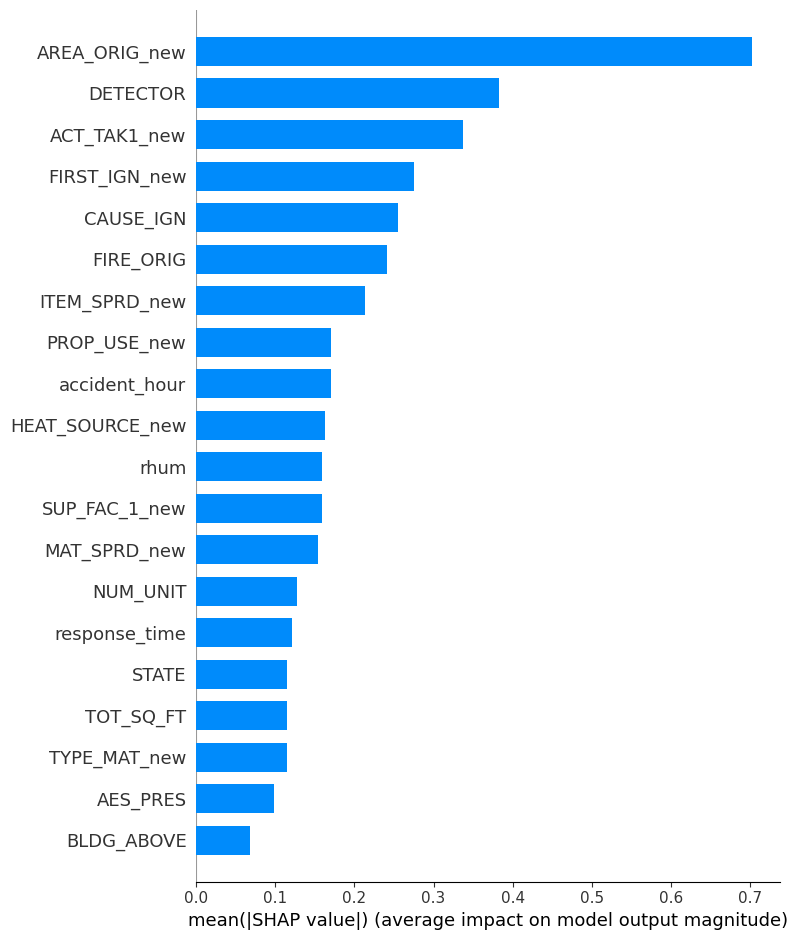

In [32]:
import shap
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values[:,:,0], X_test,plot_type='bar')

In [ ]:
joblib.dump(model, os.path.join(step2_fs_results_save_path, 'model_cont_fs_cat_best_gpu_city_v1.pkl'))
X_test.to_pickle(os.path.join(step2_fs_results_save_path, 'X_test_fs_cat_best_gpu_city_v1.pkl'))
y_test.to_pickle(os.path.join(step2_fs_results_save_path, 'y_test_fs_cat_best_gpu_city_v1.pkl'))
X_train.to_pickle(os.path.join(step2_fs_results_save_path, 'x_train_fs_cat_best_gpu_city_v1.pkl'))
y_train.to_pickle(os.path.join(step2_fs_results_save_path, 'y_train_fs_cat_best_gpu_city_v1.pkl'))

joblib.dump(shap_values, os.path.join(step2_fs_results_save_path, 'shap_values_fs_cat_best_gpu_city_v1.pkl'))
probs = model.predict_proba(X_test)
joblib.dump(probs, os.path.join(step2_fs_results_save_path, 'y_prob_fs_cat_best_gpu_city_v1.pkl'))


['/content/gdrive/Othercomputers/My Computer/Fire_risk_main/data/hongru_share//step_2/fire_spread/results/y_prob_fs_cat_best_gpu_city_v1.pkl']

In [ ]:
y_train=pd.read_pickle(os.path.join(step2_fs_results_save_path, 'y_train_fs_cat_best_gpu_city.pkl'))